In [ ]:
This part of the code is created to make link prediction and compare the different confusion matrix.

In [2]:
import networkx as nx
from networkx.algorithms import community as nxcomm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#!pip install node2vec
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
from node2vec.edges import WeightedL1Embedder
from node2vec.edges import WeightedL2Embedder
from node2vec.edges import AverageEmbedder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
#import community

C:\Users\MUSTAFA.KESER\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [95]:
#After reading the edgelist of the DE, initial source and target columns is created in order to make future analysis.

In [3]:
de_edgelist = pd.read_csv(r'C:\Users\MUSTAFA.KESER\Downloads\Project\DE_edges.csv', header=0)
edgelist = pd.concat([de_edgelist], axis=0)
edgelist.columns = ['source', 'target']
edgelist.head()

,source,target
0,0,9206
1,0,7787
2,0,2145
3,0,2684
4,0,7275


In [15]:
de_edgelist = pd.read_csv(r'C:\Users\MUSTAFA.KESER\Downloads\Project\ES_target.csv', header=0)

edgelist.shape

(4648, 6)

In [6]:
edgelist.shape

(153138, 2)

In [97]:
#After reading the target of the DE, initial  columns are created in order to make future analysis.

In [8]:

de_features = pd.read_csv(r'C:\Users\MUSTAFA.KESER\Downloads\Project\DE_target.csv', header=0, usecols=["new_id", "partner", "views", "mature", "days"])
de_features["Lang"] = "DE"
featurelist = pd.concat([de_features], axis=0)
featurelist = pd.get_dummies(featurelist, columns=["mature", "partner"])
featurelist.head()

,days,views,new_id,Lang,mature_False,mature_True,partner_False,partner_True
0,2149,162078,5079,DE,0,1,1,0
1,1574,1370,4281,DE,0,1,1,0
2,1034,6043,992,DE,0,1,1,0
3,1319,94298,9021,DE,0,1,0,1
4,2137,2323,330,DE,0,1,1,0


In [9]:
featurelist.shape

(9498, 8)

In [4]:
newfeaturelist = featurelist[["new_id","mature_True","views","days"]]

In [5]:
G = nx.from_pandas_edgelist(edgelist, source='source', target='target', edge_attr=None, create_using=nx.Graph())
print("Info:\n", nx.info(G), "\n")
print("Is directed: ", nx.is_directed(G))

Info:
 Name: 
Type: Graph
Number of nodes: 9498
Number of edges: 153138
Average degree:  32.2464 

Is directed:  False


In [6]:
edgelist["flag"] = 1
edgelist["source"] = edgelist["source"].astype("str")
edgelist["target"] = edgelist["target"].astype("str")
edgelist.shape

(153138, 3)

In [6]:
edgelist.head()

,source,target,flag
0,0,9206,1
1,0,7787,1
2,0,2145,1
3,0,2684,1
4,0,7275,1


In [7]:
degree_dict = dict(G.degree)
selected_nodes = []
for i in degree_dict:
    if degree_dict[i] >= 10:
        selected_nodes.append(str(i))
        
len(selected_nodes)

6216

In [8]:
edgelist_filtered = edgelist[edgelist["source"].isin(selected_nodes)]
edgelist_filtered = edgelist_filtered[edgelist_filtered["target"].isin(selected_nodes)]
#edgelist_filtered.head()

In [9]:
G_filtered = nx.from_pandas_edgelist(edgelist_filtered, source='source', target='target', edge_attr=None, create_using=nx.Graph())
print("Info:\n", nx.info(G_filtered), "\n")
print("Is directed: ", nx.is_directed(G_filtered))

Info:
 Name: 
Type: Graph
Number of nodes: 6216
Number of edges: 138791
Average degree:  44.6560 

Is directed:  False


In [10]:
print(len(G_filtered.nodes)**(1/2))
print(len(G_filtered.nodes)**(1/3))

78.8416133777081
18.386694855142967


In [11]:
n2v = Node2Vec(G_filtered, dimensions=20, walk_length=20, num_walks=50, p = 1, q = 1, weight_key = None, workers=4) 
model = n2v.fit(window=10)

Computing transition probabilities: 100%|██████████| 6216/6216 [02:25<00:00, 42.84it/s]


In [17]:
model.wv.save_word2vec_format('embs.txt')

**Model**

In [18]:

#edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
#edges_embs = WeightedL1Embedder(keyed_vectors=model.wv)
#edges_embs_l2 = WeightedL2Embedder(keyed_vectors=model.wv)
edges_embs_avg = AverageEmbedder(keyed_vectors=model.wv) 

In [19]:
edges_embs_avg.as_keyed_vectors().save_word2vec_format('edg_emb_avg.csv')

Generating edge features: 100%|██████████| 19322436/19322436.0 [01:31<00:00, 210246.33it/s]


In [11]:
df = pd.read_csv('edg_emb_avg.csv', sep=' ', skiprows=1, header=None)
df = df.replace(["\(", "\'", "\,", "\)"], "", regex=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,7787,7787,0.279404,0.233132,0.081362,0.125714,-0.245690,-0.261428,-0.036479,0.281306,...,0.277460,0.113721,0.022061,-0.147248,-0.012114,0.196402,0.440307,-0.141139,-0.130266,-0.322542
1,2684,7787,0.261181,0.277179,-0.078972,0.112322,-0.248376,-0.271069,-0.025516,0.336937,...,0.238205,0.089810,-0.001801,-0.161470,-0.119985,0.165167,0.432833,-0.255908,-0.052006,-0.396118
2,7787,9206,0.164360,0.293920,0.000673,0.080446,-0.394214,-0.265637,-0.119217,0.355235,...,0.147835,0.205513,-0.094790,-0.237230,0.038569,0.069267,0.347525,-0.184626,-0.228837,-0.295691
3,1638,7787,0.177047,0.158789,0.189959,0.133100,-0.203813,-0.078240,-0.042297,0.279090,...,0.248013,0.279516,0.171944,-0.240081,0.120268,0.279641,0.399552,-0.126905,-0.296621,-0.212937
4,2914,7787,0.232783,0.205942,0.160238,0.039478,-0.202915,-0.306291,0.013552,0.366387,...,0.194094,0.100811,-0.084791,-0.127706,0.025022,0.190919,0.443730,-0.142283,-0.137776,-0.263160


In [12]:
df.rename(columns={0:"source", 1:"target"}, inplace=True)

In [13]:
df = pd.merge(df, edgelist, how="left", on=["source", "target"])
df.loc[:,"flag"].fillna(0, inplace=True)

In [14]:
df.rename(columns={0:"source", 1: "target"}, inplace=True)
df.head()

,source,target,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,flag
0,7787,7787,0.279404,0.233132,0.081362,0.125714,-0.245690,-0.261428,-0.036479,0.281306,...,0.113721,0.022061,-0.147248,-0.012114,0.196402,0.440307,-0.141139,-0.130266,-0.322542,0.0
1,2684,7787,0.261181,0.277179,-0.078972,0.112322,-0.248376,-0.271069,-0.025516,0.336937,...,0.089810,-0.001801,-0.161470,-0.119985,0.165167,0.432833,-0.255908,-0.052006,-0.396118,1.0
2,7787,9206,0.164360,0.293920,0.000673,0.080446,-0.394214,-0.265637,-0.119217,0.355235,...,0.205513,-0.094790,-0.237230,0.038569,0.069267,0.347525,-0.184626,-0.228837,-0.295691,1.0
3,1638,7787,0.177047,0.158789,0.189959,0.133100,-0.203813,-0.078240,-0.042297,0.279090,...,0.279516,0.171944,-0.240081,0.120268,0.279641,0.399552,-0.126905,-0.296621,-0.212937,1.0
4,2914,7787,0.232783,0.205942,0.160238,0.039478,-0.202915,-0.306291,0.013552,0.366387,...,0.100811,-0.084791,-0.127706,0.025022,0.190919,0.443730,-0.142283,-0.137776,-0.263160,1.0


In [15]:
newfeaturelist.columns

Index(['new_id', 'mature_True', 'views', 'days'], dtype='object')

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df.to_sql('df', con=engine)
newfeaturelist.to_sql('newfeaturelist', con=engine)
result = engine.execute("""
SELECT 
source,target,2,3,4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,flag,new_id,mature_True,views,days
 FROM df a 
left join (select new_id as new_id_src, mature_True as mature_True_src, views as views_src, days as days_src from newfeaturelist) b
on a.source = b.new_id_src
left join (select new_id as new_id_trg, mature_True as mature_True_trg, views as views_trg, days as days_trg from newfeaturelist) c  on  a.target = c.new_id_trg 
""").fetchall()
newfeaturelistfinal = pd.DataFrame(result)
newfeaturelistfinal.columns = ['source', 'target','2','3','4', '5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','flag','new_id_src','mature_True_src','views_src','days_src','new_id_trg','mature_True_trg','views_trg','days_trg']
newfeaturelistfinal

In [24]:
X = df.drop(["flag", "source", "target"], axis=1)
y = df["flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

PCA(random_state=42)

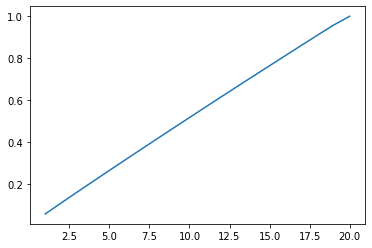

In [27]:
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_));


In [28]:
pca = PCA(n_components=16)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [29]:
(len(y_train) - y_train.sum()) / y_train.sum()


176.11406467698174

In [30]:
clf_pca = XGBClassifier(scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(), random_state=42, n_jobs=-1)

clf_pca.fit(X_train_pca, y_train)

C:\Users\MUSTAFA.KESER\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[23:28:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=176.11406467698174,
              subsample=1, tree_method='approx', validate_parameters=1,
              verbosity=None)

In [33]:
pre_test_pca = clf_pca.predict(X_test_pca)
print("Accuracy score", accuracy_score(y_test, pre_test_pca))
print("Precision score", precision_score(y_test, pre_test_pca))
print("Recall", recall_score(y_test, pre_test_pca))
print("confusion_matrix\n", confusion_matrix(y_test, pre_test_pca))

Accuracy score 0.7550720830437736
Precision score 0.015506286932954192
Recall 0.6781916843880619
confusion_matrix
 [[3628961 1174374]
 [   8777   18497]]


In [34]:
clf1 = XGBClassifier(scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(), random_state=42, n_jobs=-1)

clf1.fit(X_train_scaled, y_train)

C:\Users\MUSTAFA.KESER\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[00:04:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=176.11406467698174,
              subsample=1, tree_method='approx', validate_parameters=1,
              verbosity=None)

In [178]:
pre_test1 = clf1.predict(X_test_scaled)
print("f1-score", f1_score(y_test, pre_test1))
print("recall", recall_score(y_test, pre_test1))
print("confusion_matrix\n", confusion_matrix(y_test, pre_test1))

f1-score 0.009482537769582992
recall 0.43011456628477907
confusion_matrix
 [[2149415  545544]
 [   3482    2628]]


In [176]:
clf2 = XGBClassifier(scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(), random_state=42, n_jobs=-1)

clf2.fit(X_train, y_train)

[20:21:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=441.049369919808,
              subsample=1, tree_method='approx', validate_parameters=1,
              verbosity=None)

In [169]:
pre_test2 = clf2.predict(X_test)
print("f1-score", f1_score(y_test, pre_test2))
print("recall", recall_score(y_test, pre_test2))
print("confusion_matrix\n", confusion_matrix(y_test, pre_test2))

f1-score 0.00954769215683782
recall 0.43027823240589197
confusion_matrix
 [[2152989  541970]
 [   3481    2629]]


<Figure size 720x576 with 0 Axes>

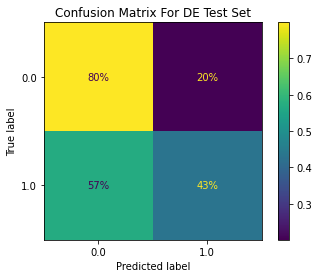

In [203]:
plt.figure(figsize=(10, 8))
plot_confusion_matrix(clf2, X_test, y_test, values_format= '.0%', normalize='true'); plt.title("Confusion Matrix For DE Test Set");

In [186]:
#Test on another community - ES
es_edgelist = pd.read_csv(r'C:\Users\MUSTAFA.KESER\Downloads\Project\ES_edges.csv', header=0)
es_edgelist.columns = ['source', 'target']
G_es = nx.from_pandas_edgelist(es_edgelist, source='source', target='target', edge_attr=None, create_using=nx.DiGraph())


es_edgelist["flag"] = 1
es_edgelist["source"] = es_edgelist["source"].astype("str")
es_edgelist["target"] = es_edgelist["target"].astype("str")

es_degree_dict = dict(G_es.degree)
es_selected_nodes = []
for i in es_degree_dict:
    if es_degree_dict[i] >= 10:
        es_selected_nodes.append(str(i))

es_edgelist_filtered = es_edgelist[es_edgelist["source"].isin(es_selected_nodes)]
es_edgelist_filtered = es_edgelist[es_edgelist["target"].isin(es_selected_nodes)]        

G_es_filtered = nx.from_pandas_edgelist(es_edgelist_filtered, source='source', target='target', edge_attr=None, create_using=nx.DiGraph())
print("Info:\n", nx.info(G_es_filtered), "\n")
print("Is directed: ", nx.is_directed(G_es_filtered))

n2v_es = Node2Vec(G_es, dimensions=20, walk_length=20, num_walks=50, p = 1, q = 1, weight_key = None, workers=4) 
model_es = n2v_es.fit(window=10)

edges_embs_es = AverageEmbedder(keyed_vectors=model_es.wv)
edges_embs_es.as_keyed_vectors().save_word2vec_format('edg_emb_es.csv')

df_es = pd.read_csv('edg_emb_es.csv', sep=' ', skiprows=1, header=None)
df_es = df_es.replace(["\(", "\'", "\,", "\)"], "", regex=True)
df_es.rename(columns={0:"source", 1:"target"}, inplace=True)
df_es = pd.merge(df_es, es_edgelist, how="left", on=["source", "target"])
df_es.loc[:,"flag"].fillna(0, inplace=True)
X_es = df_es.drop(["flag", "source", "target"], axis=1)
y_es = df_es["flag"]

pred_es = clf2.predict(X_es) 
print("f1-score", f1_score(y_es, pred_es))
print("recall", recall_score(y_es, pred_es))
print("confusion_matrix\n", confusion_matrix(y_es, pred_es))

Computing transition probabilities:   1%|          | 58/4648 [00:00<00:21, 217.38it/s]Info:
 Name: 
Type: DiGraph
Number of nodes: 4083
Number of edges: 54641
Average in degree:  13.3826
Average out degree:  13.3826 

Is directed:  True
Computing transition probabilities: 100%|██████████| 4648/4648 [00:05<00:00, 844.44it/s] 
Generating edge features: 100%|██████████| 10804276/10804276.0 [00:52<00:00, 207339.02it/s]
f1-score 0.004352274410971833
recall 0.0850812650999341
confusion_matrix
 [[9383292 1384560]
 [  33325    3099]]


<Figure size 720x576 with 0 Axes>

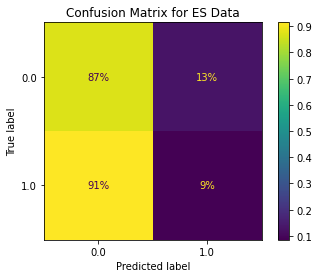

In [204]:
plt.figure(figsize=(10, 8))
plot_confusion_matrix(clf2, X_es, y_es, values_format= '.0%', normalize='true'); plt.title("Confusion Matrix for ES Data");